In [1]:
import numpy as np
import matplotlib.pyplot as plt
import sqlite3 as lite
import sys
from pyne import nucname
import pandas as pd
import pickle
from pyne.material import Material
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import sklearn
import keras.backend as K
from keras.models import Sequential
from keras.layers import Dense
from sklearn.ensemble import RandomForestRegressor
from sklearn import linear_model
from sklearn import svm
import pickle

/home/teddy/anaconda3/lib/python3.6/importlib/_bootstrap.py:219: QAWarning: pyne.data is not yet QA compliant.
  return f(*args, **kwds)
/home/teddy/anaconda3/lib/python3.6/importlib/_bootstrap.py:219: QAWarning: pyne.material is not yet QA compliant.
  return f(*args, **kwds)
Using TensorFlow backend.


In [2]:
# get sqlite cursor
df = pd.read_csv('./curated.csv', index_col=0)
df = df.loc[df['reactor_type'] == 'PWR']

# only get assemblies with enrichment bigger than 1.5 and bunrup higher than 10,000
df = df.loc[(df['init_enr'] > 1.5) & (df['bu'] > 10000)]
len(df.index)

104551

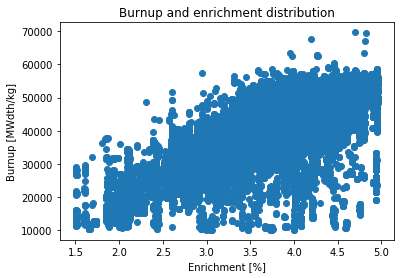

In [3]:
# visualize 
plt.scatter(df['init_enr'], df['bu'])
plt.xlabel('Enrichment [%]')
plt.ylabel('Burnup [MWdth/kg]')
plt.title('Burnup and enrichment distribution')
plt.savefig('./images/enr_bu.png', format='png')
plt.show()

# Finding the Average Assembly and its Composition 

In [4]:
avg_burnup = df['bu'].mean()
avg_enrichment = df['init_enr'].mean()

print('AVG BURNUP: %f MWD/MTHM \nAVG ENRICHMENT: %f wt%% U235' %(avg_burnup, avg_enrichment))

AVG BURNUP: 39847.564350 MWD/MTHM 
AVG ENRICHMENT: 3.730356 wt% U235


In [5]:
# average assembly composition
df['err'] = abs(df['bu'] - avg_burnup) + abs(df['init_enr'] - avg_enrichment) * 10000
minimum_err = df['err'].argmin()
df = df.drop(columns='err')
average_assem = df.loc[minimum_err]
print(average_assem)

reactor_type               PWR
total_mass             424.909
evaluation_date     2003-04-20
init_enr                  3.73
bu                       39849
zr-95              0.000104742
zr-93                0.0929408
ra-226              3.1274e-11
ru-103               5.978e-06
ru-106              0.00618652
sb-124             7.45681e-08
sb-125             0.000616913
pu-238               0.0367202
pu-239                0.673003
np-237               0.0587654
nb-95              0.000123533
pa-231             1.40854e-07
pd-107               0.0277897
pm-147               0.0105453
pu-240                0.260229
pu-241                0.160302
pu-244              4.2894e-06
pu-242               0.0627791
i-129                0.0191043
h-3                6.19366e-06
kr-85               0.00250212
nb-94              1.60467e-07
cm-248             3.91648e-08
cs-134              0.00861031
cs-135               0.0600425
                      ...     
eu-154              0.00305445
eu-155  

/home/teddy/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:3: FutureWarning: 'argmin' is deprecated, use 'idxmin' instead. The behavior of 'argmin'
will be corrected to return the positional minimum in the future.
Use 'series.values.argmin' to get the position of the minimum now.
  This is separate from the ipykernel package so we can avoid doing imports until


In [6]:
# get isotope dictionary
avg_recipe = average_assem.iloc[5:].to_dict()
# change other to h-1
avg_recipe['h-1'] = avg_recipe.pop('other')
avg_recipe

{'zr-95': 0.00010474194239237108,
 'zr-93': 0.092940813209416606,
 'ra-226': 3.1273971603331539e-11,
 'ru-103': 5.9780021133936896e-06,
 'ru-106': 0.0061865229966887036,
 'sb-124': 7.4568067515632764e-08,
 'sb-125': 0.00061691329202252722,
 'pu-238': 0.036720156551167428,
 'pu-239': 0.67300297240114937,
 'np-237': 0.05876537799858321,
 'nb-95': 0.0001235333283126505,
 'pa-231': 1.4085442294703106e-07,
 'pd-107': 0.027789747922496347,
 'pm-147': 0.010545345709316581,
 'pu-240': 0.26022882546615861,
 'pu-241': 0.16030215410829141,
 'pu-244': 4.2893998479674471e-06,
 'pu-242': 0.062779115057577037,
 'i-129': 0.019104337869990988,
 'h-3': 6.1936626430600426e-06,
 'kr-85': 0.002502123278160736,
 'nb-94': 1.6046698469554653e-07,
 'cm-248': 3.916475527701225e-08,
 'cs-134': 0.0086103071481187753,
 'cs-135': 0.060042456149434362,
 'cm-245': 0.00041304924113163064,
 'cm-244': 0.0060223370180438633,
 'cm-246': 3.7532450477631677e-05,
 'cm-247': 5.429607751306751e-07,
 'eu-152': 2.976113003019470

# We store all the assemblies in a dictionary, one with the composition with UNF-ST&DARDS, and the other with recipe composition

In [7]:
iso_list = list(df)[5:]
iso_list

['zr-95',
 'zr-93',
 'ra-226',
 'ru-103',
 'ru-106',
 'sb-124',
 'sb-125',
 'pu-238',
 'pu-239',
 'np-237',
 'nb-95',
 'pa-231',
 'pd-107',
 'pm-147',
 'pu-240',
 'pu-241',
 'pu-244',
 'pu-242',
 'i-129',
 'h-3',
 'kr-85',
 'nb-94',
 'cm-248',
 'cs-134',
 'cs-135',
 'cm-245',
 'cm-244',
 'cm-246',
 'cm-247',
 'eu-152',
 'cs-137',
 'eu-154',
 'eu-155',
 'am-241',
 'am-242m',
 'am-243',
 'cf-251',
 'cf-249',
 'ag-108m',
 'ag-110m',
 'ac-227',
 'cm-243',
 'cm-242',
 'c-14',
 'ce-144',
 'u-234',
 'u-235',
 'u-236',
 'y-90',
 'u-238',
 'th-229',
 'tc-99',
 'sm-151',
 'se-79',
 'sr-90',
 'sn-126',
 'th-232',
 'th-230',
 'u-232',
 'u-233',
 'other']

In [8]:
model_dict = pickle.load(open('./script/ann_model.pkl', 'rb'))
model_dict

{'model': <keras.engine.sequential.Sequential at 0x7f46a21af978>,
 'xscaler': MinMaxScaler(copy=True, feature_range=(0, 1)),
 'yscaler': MinMaxScaler(copy=True, feature_range=(0, 1)),
 'iso_list': ['zr-95',
  'zr-93',
  'ra-226',
  'ru-103',
  'ru-106',
  'sb-124',
  'sb-125',
  'pu-238',
  'pu-239',
  'np-237',
  'nb-95',
  'pa-231',
  'pd-107',
  'pm-147',
  'pu-240',
  'pu-241',
  'pu-244',
  'pu-242',
  'i-129',
  'h-3',
  'kr-85',
  'nb-94',
  'cm-248',
  'cs-134',
  'cs-135',
  'cm-245',
  'cm-244',
  'cm-246',
  'cm-247',
  'eu-152',
  'cs-137',
  'eu-154',
  'eu-155',
  'am-241',
  'am-242m',
  'am-243',
  'cf-251',
  'cf-249',
  'ag-108m',
  'ag-110m',
  'ac-227',
  'cm-243',
  'cm-242',
  'c-14',
  'ce-144',
  'u-234',
  'u-235',
  'u-236',
  'y-90',
  'u-238',
  'th-229',
  'tc-99',
  'sm-151',
  'se-79',
  'sr-90',
  'sn-126',
  'th-232',
  'th-230',
  'u-232',
  'u-233',
  'other']}

In [9]:
def get_a(f):
    z = ''
    for i in f:
        if i.isdigit():
            z += i
    return int(z)


def predict(model_dict, enr_bu):
        model = model_dict['model']
        xscaler = model_dict['xscaler']
        yscaler = model_dict['yscaler']
        iso_list = model_dict['iso_list']
        x = xscaler.transform(enr_bu)
        y = yscaler.inverse_transform(model.predict(x))[0]
        comp_dict = {}
        for indx, iso in enumerate(iso_list):
            comp_dict[iso] = y[indx]
        return comp_dict

In [10]:
def get_lump_recipe_rom_dict(df, model_dict):
    lump_dict = {}
    recipe_dict = {}
    rom_dict = {}
    for index, row in df.iterrows():
        eval_date = row['evaluation_date']
        if eval_date not in lump_dict.keys():
            rom_dict[eval_date] = {}
            lump_dict[eval_date] = {}
            recipe_dict[eval_date] = {}
            lump_dict[eval_date]['mass'] = row['total_mass']
            lump_dict[eval_date]['bu'] = row['bu']
            lump_dict[eval_date]['init_enr'] = row['init_enr']
            recipe_dict[eval_date]['mass'] = row['total_mass']
            rom_dict[eval_date]['mass'] = row['total_mass']
            lump_dict[eval_date]['comp'] = {}
            rom_dict[eval_date]['comp'] = {}

            enr_bu = [[row['init_enr'], row['bu']]]
            rom_dict[eval_date]['enr_bu'] = enr_bu
            rom_comp_dict = predict(model_dict, enr_bu)
            for iso in iso_list:
                lump_dict[eval_date]['comp'][iso] = row[iso] * 1e-2 * row['total_mass']
                # percentage to mass
                rom_dict[eval_date]['comp'][iso] = rom_comp_dict[iso] * 1e-2 * row['total_mass']
            recipe_dict[eval_date]['comp'] = avg_recipe
        else:
            lump_dict[eval_date]['mass'] += row['total_mass']
            rom_dict[eval_date]['mass'] += row['total_mass']
            enr_bu = [[row['init_enr'], row['bu']]]
            rom_comp_dict = predict(model_dict, enr_bu)
            for iso in iso_list:
                lump_dict[eval_date]['comp'][iso] += row[iso] * 1e-2 * row['total_mass']
                rom_dict[eval_date]['comp'][iso] += rom_comp_dict[iso] * 1e-2 * row['total_mass']
            recipe_dict[eval_date]['mass'] += row['total_mass']
        
    # normalize lump dict compositions
    for key, val in lump_dict.items():
        for key2, val2 in lump_dict[key]['comp'].items():
            lump_dict[key]['comp'][key2] = lump_dict[key]['comp'][key2] / val['mass']
            rom_dict[key]['comp'][key2] = rom_dict[key]['comp'][key2] / rom_dict[key]['mass']

    return lump_dict, recipe_dict, rom_dict

In [11]:
def get_data_model_recipe_dict(df, model_dict):
    data_dict = {}
    rom_dict = {}
    recipe_dict = {}
    i = 0
    for index, row in df.iterrows():
        data_dict[i] = {}
        rom_dict[i] = {}
        recipe_dict[i] = {}
        data_dict[i]['evaluation_date'] = row['evaluation_date']
        data_dict[i]['mass'] = row['total_mass']
        data_dict[i]['bu'] = row['bu']
        data_dict[i]['init_enr'] = row['init_enr']
        recipe_dict[i]['mass'] = row['total_mass']
        rom_dict[i]['mass'] = row['total_mass']
        data_dict[i]['comp'] = {}
        rom_dict[i]['comp'] = {}
        
        enr_bu = [[row['init_enr'], row['bu']]]
        rom_dict[i]['enr_bu'] = enr_bu
        rom_comp_dict = predict(model_dict, enr_bu)
        for iso in iso_list:
            if iso == 'other':
                isoz = 'h-1'
            else:
                isoz = iso
            data_dict[i]['comp'][isoz] = row[iso] * 1e-2 * row['total_mass']
            rom_dict[i]['comp'][isoz] = rom_comp_dict[iso] * 1e-2 * row['total_mass']
        recipe_dict[i]['comp'] = avg_recipe
        i += 1
    
    for key, val in data_dict.items():
        for key2, val2 in data_dict[key]['comp'].items():
            data_dict[key]['comp'][key2]  = data_dict[key]['comp'][key2] / val['mass']
            rom_dict[key]['comp'][key2] = rom_dict[key]['comp'][key2] / rom_dict[key]['mass']
    
    return data_dict, recipe_dict, rom_dict

In [12]:
# this takes a while:
lump_dict, recipe_dict, rom_dict = get_data_model_recipe_dict(df, model_dict)

In [13]:
f = open('lump_recipe_rom.pkl', 'wb')
pickle.dump([lump_dict, recipe_dict, rom_dict], f)
f.close()

## =======================================
## =======================================
## Pickled dictionary of all the dictionary of assemblies

In [9]:
comparison_list = pickle.load(open('./lump_recipe_rom.pkl',"rb"))
lump_dict = comparison_list[0]
recipe_dict = comparison_list[1]
rom_dict = comparison_list[2]

## Compare the difference between udb and rom results per assembly

In [10]:
for_plot = {'bu': [],
            'init_enr': [],
            'rmse': [],
            'rmpe': []}

for key, val in lump_dict.items():
    from_udb = val['comp']
    from_rom = rom_dict[key]['comp']
    rmse = 0
    rmpe = 0
    for iso, val2 in from_udb.items():
        rom_comp = from_rom[iso]
        udb_comp = val2
        rmse += (rom_comp - udb_comp)**2
        rmpe += (udb_comp - rom_comp) / udb_comp
    for_plot['bu'].append(val['bu'])
    for_plot['init_enr'].append(val['init_enr'])
    for_plot['rmse'].append(rmse)
    for_plot['rmpe'].append(rmpe)

    

## Total RMSE and RMPE for every assembly in UDB

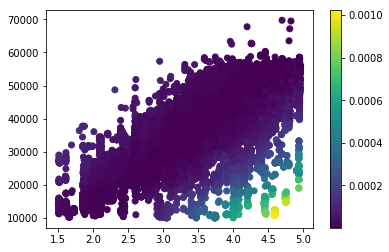

In [11]:
plt.scatter(for_plot['init_enr'], for_plot['bu'], c=for_plot['rmse'])
plt.colorbar()
plt.show()

[78342, 90363, 88793, 74751, 85032, 37759, 37755, 37761, 37748, 37760]


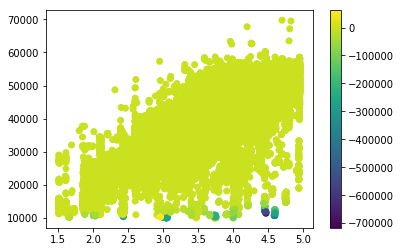

In [12]:
kill_indx = sorted(range(len(for_plot['rmpe'])), key=lambda i: for_plot['rmpe'][i])[:5]
kill_indx += sorted(range(len(for_plot['rmpe'])), key=lambda i: for_plot['rmpe'][i])[-5:]
new_list = [i for indx, i in enumerate(for_plot['rmpe']) if indx not in kill_indx]
x = [i for indx, i in enumerate(for_plot['init_enr']) if indx not in kill_indx]
y = [i for indx, i in enumerate(for_plot['bu']) if indx not in kill_indx]
print(kill_indx)
plt.scatter(x, y, c=new_list)
plt.colorbar()
plt.show()

## Error for all isotopes for single enrichment / burnup

In [19]:
import random
rand_indx = random.sample(range(1, len(lump_dict.keys())), 10)
print(rand_indx)


enr_bu_dict = {}
for i in rand_indx:
    enr_bu_dict[i] = {}
    enr_bu_dict[i]['enr'] = lump_dict[i]['init_enr']
    enr_bu_dict[i]['bu'] = lump_dict[i]['bu']
    
    enr_bu_dict[i]['err'] = {}
    for iso in iso_list:
        if iso == 'other':
            continue
        err = (lump_dict[i]['comp'][iso] - rom_dict[i]['comp'][iso]) / lump_dict[i]['comp'][iso] * 100
        enr_bu_dict[i]['err'][iso] = err


[3792, 76376, 85494, 56691, 97034, 37238, 62472, 5849, 13489, 91401]


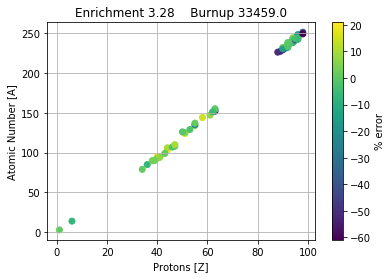

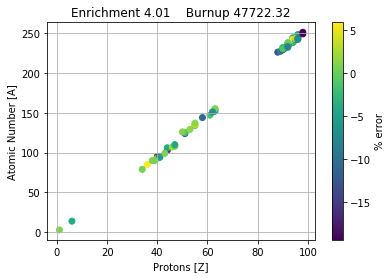

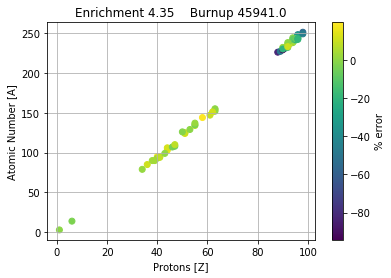

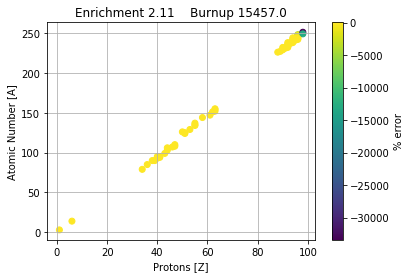

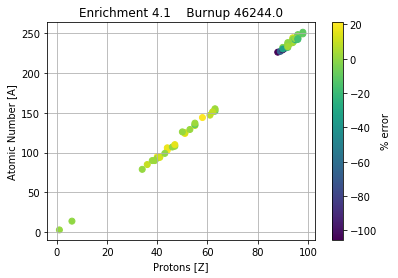

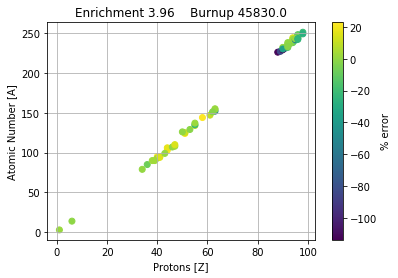

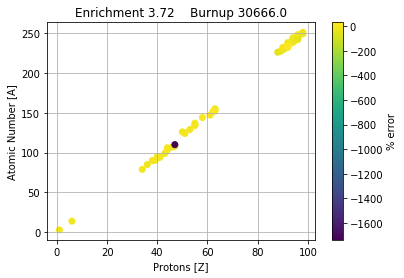

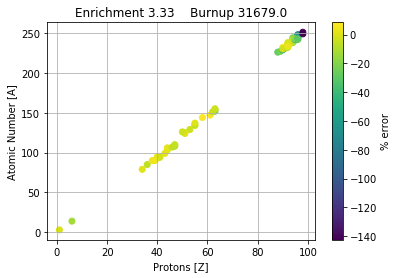

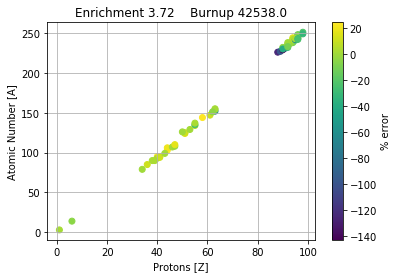

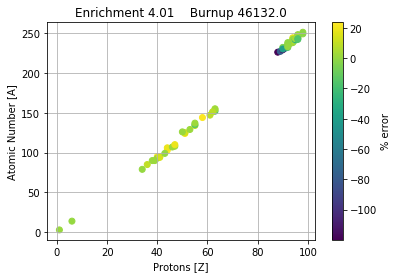

In [20]:
for date, val in enr_bu_dict.items():
    z = []
    a = []
    for iso in val['err']:
        z.append(nucname.zzzaaa(iso) // 1000)
        a.append(nucname.zzzaaa(iso) % 1000)
    plt.scatter(z, a, c=list(val['err'].values()))
    enr = round(float(val['enr']), 2) 
    bu = round(float(val['bu']), 2)
    plt.title('Enrichment ' + str(enr) + '    ' + 'Burnup ' + str(bu))
    plt.xlabel('Protons [Z]')
    plt.ylabel('Atomic Number [A]')
    cbar = plt.colorbar()
    cbar.set_label('% error')    
    plt.grid()
    plt.savefig('./images/err/' + str(enr).replace('.', '-') + '_' + str(bu).replace('.', '-') + '.png', format='png')
    plt.show()
    plt.close()

# Then we convert the assembly to `pyne` material, for decay and analysis

In [21]:
def attach_pyne_material(assem_dict):
    for key, value in assem_dict.items():
        pyne_mat = Material(value['comp'], value['mass'])
        assem_dict[key]['mat'] = pyne_mat
    return assem_dict

In [22]:
lump_dict = attach_pyne_material(lump_dict)
recipe_dict = attach_pyne_material(recipe_dict)
rom_dict = attach_pyne_material(rom_dict)

### Data vs Model decay and activity

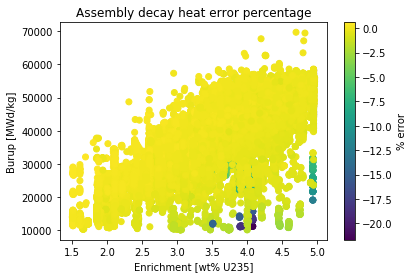

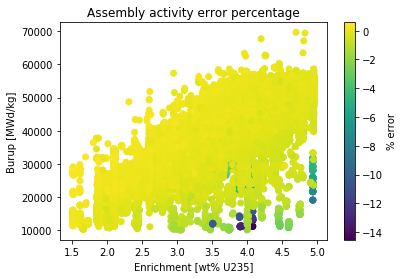

In [24]:
bu_list = []
enr_list = []
decay_heat_err_list = []
activity_err_list = []

# compare decay heat / activity error for each assemblys 

def get_err(one, two):
    tot = 0
    for key,val in one.items():
        try:
            if np.isnan(val) or np.isnan(two[key]):
               continue
            tot += (val - two[key])
        except:
            continue
    return tot / np.nansum(list(one.values()))

for key, val in lump_dict.items():
    bu_list.append(val['bu'])
    enr_list.append(val['init_enr'])
    model_mat = rom_dict[key]['mat']
    lump_mat = val['mat']
    decay_heat_err = get_err(lump_mat.decay_heat(), model_mat.decay_heat())
    decay_heat_err_list.append(decay_heat_err)
    activity_err = get_err(lump_mat.activity(), model_mat.activity())
    activity_err_list.append(activity_err)

    

plt.scatter(enr_list, bu_list, c=decay_heat_err_list)
cbar = plt.colorbar()
cbar.set_label('% error')
plt.xlabel('Enrichment [wt% U235]')
plt.ylabel('Burup [MWd/kg]')
plt.title('Assembly decay heat error percentage')
plt.savefig('./images/assem_dh.png', format='png')
plt.show()
plt.close()


plt.scatter(enr_list, bu_list, c=activity_err_list)
cbar = plt.colorbar()
cbar.set_label('% error')
plt.xlabel('Enrichment [wt% U235]')
plt.ylabel('Burup [MWd/kg]')
plt.title('Assembly activity error percentage')
plt.savefig('./images/assem_act.png', format='png')
plt.show()
plt.close()


### Data vs Average decay and activity

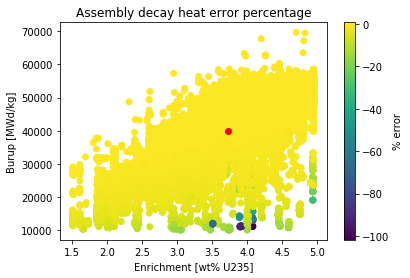

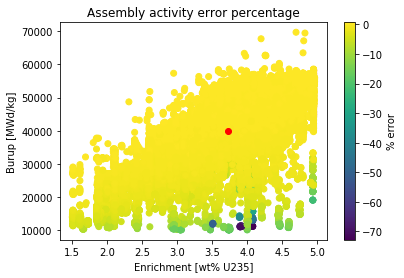

In [25]:
# error for all assembly metric for average recipe
bu_list = []
enr_list = []
decay_heat_err_list = []
activity_err_list = []

# compare decay heat / activity error for each assemblys 


for key, val in lump_dict.items():
    bu_list.append(val['bu'])
    enr_list.append(val['init_enr'])
    recipe_mat = recipe_dict[key]['mat']
    lump_mat = val['mat']
    decay_heat_err = get_err(lump_mat.decay_heat(), recipe_mat.decay_heat())
    decay_heat_err_list.append(decay_heat_err)
    activity_err = get_err(lump_mat.activity(), recipe_mat.activity())
    activity_err_list.append(activity_err)

plt.scatter(enr_list, bu_list, c=decay_heat_err_list)
cbar = plt.colorbar()
cbar.set_label('% error')    
plt.scatter(average_assem['init_enr'], average_assem['bu'], color='red')
plt.xlabel('Enrichment [wt% U235]')
plt.ylabel('Burup [MWd/kg]')
plt.title('Assembly decay heat error percentage')
plt.savefig('./images/assem_dh_recipe.png', format='png')
plt.show()
plt.close()

plt.scatter(enr_list, bu_list, c=activity_err_list)
cbar = plt.colorbar()
cbar.set_label('% error')
plt.scatter(average_assem['init_enr'], average_assem['bu'], color='red')

plt.xlabel('Enrichment [wt% U235]')
plt.ylabel('Burup [MWd/kg]')
plt.title('Assembly activity error percentage')
plt.savefig('./images/assem_act_recipe.png', format='png')
plt.show()
plt.close()


# Then we decay the assemblies to 2020:

In [26]:
def find_diff_time_secs(year, month, day, evaluation_date):
    # the UNF-ST&DARDS data format is YYYY-MM-DD
    ev_year = int(evaluation_date[:4])
    ev_month = int(evaluation_date[5:7])
    ev_day = int(evaluation_date[8:])
    
    dyear = 0
    dmonth = 0
    dday = day - ev_day
    if dday < 0:
        dmonth -= 1
        dday += 30
    dmonth += month - ev_month
    if dmonth < 0:
        dyear -= 1
        dmonth += 12
    dyear += year - ev_year
    if dyear < 0:
        raise ValueError('Cannot go back in time man')
    
    time_in_sec = dyear * (365 * 24 * 3600) + dmonth * (30 * 24 * 3600) + dday * (24 * 3600)
    return time_in_sec

In [29]:
def decay_assemblies(assem_dict, year=2020):
    # just put the pyne materials in there, other categories are unnecessary
    decayed_dict = {}
    for key, value in assem_dict.items():
        # to 2020-07-01
        eval_date = lump_dict[key]['evaluation_date']
        decay_time = find_diff_time_secs(year, 7, 1, eval_date)
        decayed_dict[key] = {}
        decayed_dict[key]['mass'] = assem_dict[key]['mass']
        decayed_dict[key]['mat'] = assem_dict[key]['mat'].decay(decay_time)
    return decayed_dict

In [30]:
decayed_lump_dict_3000 = decay_assemblies(lump_dict, 3000)
decayed_recipe_dict_3000 = decay_assemblies(recipe_dict, 3000)
decayed_rom_dict_3000 = decay_assemblies(rom_dict, 3000)

KeyError: 'evaluation_date'

In [ ]:
bu_list = []
enr_list = []
decay_heat_err_list = []
activity_err_list = []

# compare decay heat / activity error for each assemblys at year 3000

for key, val in decayed_lump_dict_3000.items():
    bu_list.append(lump_dict[key]['bu'])
    enr_list.append(lump_dict[key]['init_enr'])
    model_mat = decayed_rom_dict_3000[key]['mat']
    lump_mat = val['mat']
    decay_heat_err = get_err(lump_mat.decay_heat(), model_mat.decay_heat())
    decay_heat_err_list.append(decay_heat_err)
    activity_err = get_err(lump_mat.activity(), model_mat.activity())
    activity_err_list.append(activity_err)

    

plt.scatter(enr_list, bu_list, c=decay_heat_err_list)
plt.colorbar()
plt.xlabel('Enrichment [wt% U235]')
plt.ylabel('Burup [MWd/kg]')
plt.title('Assembly decay heat at year 3000 error percentage')
plt.show()
plt.close()


plt.scatter(enr_list, bu_list, c=activity_err_list)
plt.colorbar()
plt.xlabel('Enrichment [wt% U235]')
plt.ylabel('Burup [MWd/kg]')
plt.title('Assembly activity at year 3000 error percentage')
plt.show()
plt.close()

In [ ]:
decayed_lump_dict = decay_assemblies(lump_dict)
decayed_recipe_dict = decay_assemblies(recipe_dict)
decayed_rom_dict = decay_assemblies(rom_dict)

# Then we compare the metrics:

In [ ]:
import math

def nansum(dictionary):
    summ = 0 
    for key, value in dictionary.items():
        # skip metastable isotopes
        if str(key)[-1] == '1':
            continue
        if not math.isnan(value):
             summ += value
    return summ

def decay_heatz(assem_dict, time=0):
    total_heat = 0
    for key, value in assem_dict.items():
        after = assem_dict[key]['mat'].decay(time)
        total_heat += nansum(after.decay_heat())
    return total_heat

def total_massz(assem_dict, time=0):
    total_mass = 0
    for key, value in assem_dict.items():
        after = assem_dict[key]['mat'].decay(time)
        total_mass += value['mass']
    return total_mass

def activityz(assem_dict, time=0):
    activity = 0
    for key, value in assem_dict.items():
        after = assem_dict[key]['mat'].decay(time)
        activity += nansum(after.activity())
    return activity

def isotopics(assem_dict, time=0):
    iso_dict = {}
    for key, value in assem_dict.items():
        for key2, value2 in value['mat'].mult_by_mass().items():
            if key2 not in iso_dict.keys():
                iso_dict[key2] = value2
            else:
                iso_dict[key2] += value2
    return iso_dict


In [ ]:
post_lump = isotopics(decayed_lump_dict)
post_recipe = isotopics(decayed_recipe_dict)
post_rom = isotopics(decayed_rom_dict)

pre_lump = isotopics(lump_dict)
pre_recipe = isotopics(recipe_dict)
pre_rom = isotopics(rom_dict)

In [ ]:
top_iso_list = sorted(pre_lump, key=pre_lump.get, reverse=True)
for i in top_iso_list[:10]:
    print(nucname.name(i))

In [ ]:
# check pu-239 amount
# total mass -> should be the same
print('UNIT: T')

print('\nPost-decay')
print(post_lump[942390000] * 1e-3) 
print(post_recipe[942390000] * 1e-3)
print(post_rom[942390000] * 1e-3)

print('\nPre-decay')
print(pre_lump[942390000] * 1e-3)
print(pre_recipe[942390000] * 1e-3)
print(pre_rom[942390000] * 1e-3)



In [ ]:
# check cs137 amount
print('CS 137')
print('UNIT: T')

print('\nPost-decay')
print(post_lump[551370000] * 1e-3) 
print(post_recipe[551370000] * 1e-3)
print(post_rom[551370000] * 1e-3)

print('\nPre-decay')
print(pre_lump[551370000] * 1e-3)
print(pre_recipe[551370000] * 1e-3)
print(pre_rom[551370000] * 1e-3)


In [ ]:
# check u235 amount
print('U235')
print('UNIT: T')

print('\nPost-decay')
print(post_lump[922350000] * 1e-3) 
print(post_recipe[922350000] * 1e-3)
print(post_rom[922350000] * 1e-3)

print('\nPre-decay')
print(pre_lump[922350000] * 1e-3)
print(pre_recipe[922350000] * 1e-3)
print(pre_rom[922350000] * 1e-3)

In [ ]:
# check u238 amount
print('U238')
print('UNIT: T')

print('\nPost-decay')
print(post_lump[922380000] * 1e-3) 
print(post_recipe[922380000] * 1e-3)
print(post_rom[922380000] * 1e-3)

print('\nPre-decay')
print(pre_lump[922380000] * 1e-3)
print(pre_recipe[922380000] * 1e-3)
print(pre_rom[922380000] * 1e-3)

In [ ]:
# check tc99 amount
print('Tc99')
print('UNIT: T')

print('\nPost-decay')
print(post_lump[430990000] * 1e-3) 
print(post_recipe[430990000] * 1e-3)
print(post_rom[430990000] * 1e-3)

print('\nPre-decay')
print(pre_lump[430990000] * 1e-3)
print(pre_recipe[430990000] * 1e-3)
print(pre_rom[430990000] * 1e-3)

In [ ]:
# total mass -> should be the same
print('UNIT: T')

print('\nPost-decay')
print(total_massz(decayed_lump_dict) * 1e-3) 
print(total_massz(decayed_recipe_dict) * 1e-3)
print(total_massz(decayed_rom_dict) * 1e-3)

print('\nPre-decay')
print(total_massz(lump_dict) * 1e-3)
print(total_massz(recipe_dict) * 1e-3)
print(total_massz(rom_dict) * 1e-3)


In [ ]:
print('UNIT: MW')
print('\nPost-decay')
print(decay_heatz(decayed_lump_dict) * 1e3) 
print(decay_heatz(decayed_recipe_dict) * 1e3)
print(decay_heatz(decayed_rom_dict) * 1e3)

print('\nPre-decay')
print(decay_heatz(lump_dict)* 1e3)
print(decay_heatz(recipe_dict)* 1e3)
print(decay_heatz(rom_dict) * 1e3)


In [ ]:
print('UNIT: Bq')
print('\nPost-decay')
print(activityz(decayed_lump_dict) * 1e3)
print(activityz(decayed_recipe_dict)* 1e3)
print(activityz(decayed_rom_dict) * 1e3)

print('\nPre-decay')
print(activityz(lump_dict) * 1e3)
print(activityz(recipe_dict) * 1e3)
print(activityz(rom_dict) * 1e3)

# Checking that our results match the data, we do a direct comparison between the decayed material using UNF-ST&DARDS and an Avg. Recipe

In [ ]:
# lump the materials to one material to make this easier
def lump_dict_to_mat(assem_dict):
    out_mat = Material({'H1':1},1e-6)
    for key, val in assem_dict.items():
        out_mat = out_mat + assem_dict[key]['mat']
    return out_mat

In [ ]:
decayed_lump_mat = lump_dict_to_mat(decayed_lump_dict)
decayed_recipe_mat = lump_dict_to_mat(decayed_recipe_dict)
decayed_rom_mat = lump_dict_to_mat(decayed_rom_dict)

In [ ]:
def plot_decay_heat(mat, start_year, end_year, n_grid=100):
    heat_array = np.zeros(n_grid)
    time_array = np.linspace(0, ((end_year - start_year) * (3600 * 24 * 365)), n_grid)
    time_axis = np.linspace(start_year, end_year, n_grid)
    for index, time in enumerate(time_array):
        decayed = mat.decay(time)
        heat_array[index] = nansum(decayed.decay_heat())
    return time_axis, heat_array * 1e3

def plot_activity(mat, start_year, end_year, n_grid=100):
    heat_array = np.zeros(n_grid)
    time_array = np.linspace(0, ((end_year - start_year) * (3600 * 24 * 365)), n_grid)
    time_axis = np.linspace(start_year, end_year, n_grid)
    for index, time in enumerate(time_array):
        decayed = mat.decay(time)
        heat_array[index] = nansum(decayed.activity())
    return time_axis, heat_array * 1e3

def get_fissile_eq(mat, thermal=False):
    # from plutonium fuel - an assessment (NEA)
    eq = 0
    if thermal:
        eq += mat.mult_by_mass()[922350000] * 0.8
        eq += mat.mult_by_mass()[942380000] * (-1.0)
        eq += mat.mult_by_mass()[942390000] * (1.0)
        eq += mat.mult_by_mass()[942400000] * (-0.4)
        eq += mat.mult_by_mass()[942410000] * (1.3)
        eq += mat.mult_by_mass()[942420000] * (-1.4)
        eq += mat.mult_by_mass()[952410000] * (-2.2)
    else:
        # fast spectrum (super-phenix)
        eq += mat.mult_by_mass()[922350000] * 0.8
        eq += mat.mult_by_mass()[942380000] * (0.44)
        eq += mat.mult_by_mass()[942390000] * (1.0)
        eq += mat.mult_by_mass()[942400000] * (0.14)
        eq += mat.mult_by_mass()[942410000] * (1.5)
        eq += mat.mult_by_mass()[942420000] * (0.037)
        eq += mat.mult_by_mass()[952410000] * (-0.33)
    return eq * 1e-3

def plot_fissile_quality(mat, start_year, end_year, n_grid=100):
    qual_array = np.zeros(n_grid)
    time_array = np.linspace(0, ((end_year - start_year) * (3600 * 24 * 365)), n_grid)
    time_axis = np.linspace(start_year, end_year, n_grid)
    for index, time in enumerate(time_array):
        decayed = mat.decay(time)
        qual_array[index] = get_fissile_eq(decayed)
    return time_axis, qual_array

In [ ]:
# decay heat at discrete times

# to 2100
print('At 2100:')
t_to_2100 = 80 * (3600 * 24 * 365)
acc = nansum(decayed_lump_mat.decay(t_to_2100).decay_heat())
rec = nansum(decayed_rom_mat.decay(t_to_2100).decay_heat())
print(acc)
print(rec)
print('err %')
print((acc-rec)/acc * 100)
print('\n')

print('At 3100')
t_to_3100 = 1080 * (3600 * 24 * 365)
acc = nansum(decayed_lump_mat.decay(t_to_3100).decay_heat())
rec = nansum(decayed_rom_mat.decay(t_to_3100).decay_heat())
print(acc)
print(rec)
print('err %')
print((acc-rec)/acc * 100)
print('\n')


In [ ]:
# activity at discrete times
from decimal import Decimal

# to 2100

t_to_2100 = 80 * (3600 * 24 * 365)
acc = nansum(decayed_lump_mat.decay(t_to_2100).activity())
rec = nansum(decayed_rom_mat.decay(t_to_2100).activity())
print(acc)
print(rec)
print('err %')
print((acc-rec)/acc * 100)
print('\n')


t_to_3100 = 1080 * (3600 * 24 * 365)
acc = nansum(decayed_lump_mat.decay(t_to_3100).activity())
rec = nansum(decayed_rom_mat.decay(t_to_3100).activity())
print('%.2E' % Decimal(acc))
print('%.2E' % Decimal(rec))
print('err %')
print((acc-rec)/acc * 100)
print('\n')


In [ ]:
time_acc, heat_acc = plot_decay_heat(decayed_lump_mat, 2020, 3100)
time_rom, heat_rom = plot_decay_heat(decayed_rom_mat, 2020, 3100)
time_rec, heat_rec = plot_decay_heat(decayed_recipe_mat, 2020, 3100)

time_acc, act_acc = plot_activity(decayed_lump_mat, 2020, 3100)
time_rom, act_rom = plot_activity(decayed_rom_mat, 2020, 3100)
time_rec, act_rec = plot_activity(decayed_recipe_mat, 2020, 3100)

time_acc, fiss_acc = plot_fissile_quality(decayed_lump_mat, 2020, 3100)
time_rom, fiss_rom = plot_fissile_quality(decayed_rom_mat, 2020, 3100)
time_rec, fiss_rec = plot_fissile_quality(decayed_recipe_mat, 2020, 3100)

In [ ]:
err_heat = (heat_acc - heat_rec) / heat_acc * 100
err_act = (act_acc - act_rec) / act_acc * 100
err_heat_rom = (heat_acc - heat_rom) / heat_acc * 100
err_act_rom = (act_acc - act_rom) / act_acc * 100

In [ ]:
plt.plot(time_acc, fiss_acc, label='Data')
plt.plot(time_rec, fiss_rom, label='Model')
plt.plot(time_rec, fiss_rec, label='Recipe')

plt.title('Fissile Quality vs time')
plt.xlabel('Year')
plt.ylabel('Effective Pu239 [t]')
plt.legend()
plt.grid()
plt.savefig('./images/fiss.png', format='png')
plt.show()
plt.close

In [ ]:
plt.plot(time_acc, heat_acc, label='UNF-ST&DARDS')
plt.plot(time_rec, heat_rec, label='AVG RECIPE')
plt.plot(time_rec, heat_rom, label='ROM')

plt.title('Decay Heat vs time')
plt.xlabel('Year')
plt.ylabel('Decay Heat [MW]')
plt.legend()
plt.grid()
plt.savefig('./images/heat.png', format='png')
plt.show()
plt.close

In [ ]:
plt.semilogy(time_acc, act_acc, label='UNF-ST&DARDS')
plt.semilogy(time_rec, act_rec, label='AVG RECIPE')
plt.semilogy(time_rom, act_rom, label='ROM')
plt.title('Activity vs time')
plt.xlabel('Year')
plt.ylabel('Activity [Bq]')
plt.legend()
plt.grid()
plt.savefig('./images/activity.png', format='png')
plt.show()
plt.close

In [ ]:
plt.plot(time_acc, err_heat, label='Recipe Error [Decay Heat]', color='b')
plt.plot(time_acc, err_act, label='Recipe Error [Activity]', color='r')

plt.plot(time_acc, err_heat_rom, label='Model Error [Decay Heat]', color='b', linestyle='--')
plt.plot(time_acc, err_act_rom, label='Model Error [Activity]', color='r', linestyle='--')

plt.xlabel('Year')
plt.ylabel('Relative Error [%]')
plt.legend()
plt.grid()
plt.title('Waste management metrics relative error')
plt.tight_layout
plt.savefig('./images/ha_err.png', format='png')
plt.show()
plt.close()

# Compare isotopic differences

In [ ]:
def compare_isotope(acc_mat, rec_mat, isotope_list, rel_err=False):
    # convert to canonical / pyne-standard form
    isotope_list = [nucname.id(x) for x in isotope_list]
    iso_diff_dict = {}
    for iso in isotope_list:
        acc_qty = acc_mat.mult_by_mass()[iso]
        rec_qty = rec_mat.mult_by_mass()[iso]
        if rel_err:
            iso_diff_dict[nucname.name(iso)] = (acc_qty - rec_qty) / acc_qty * 100
        else:
            iso_diff_dict[nucname.name(iso)] = (acc_qty - rec_qty) * 1e-3
    return iso_diff_dict

def compare_element(acc_mat, rec_mat, zz_list, rel_err=False):
    el_diff_dict = {}
    for zz in zz_list:
        acc_qty = 0
        rec_qty = 0
        for key, val in acc_mat.mult_by_mass().items():
            if key // 10000000 == zz:
                acc_qty += acc_mat.mult_by_mass()[key]
                rec_qty += rec_mat.mult_by_mass()[key]
        if rel_err:
            el_diff_dict[zz] = (acc_qty - rec_qty) / acc_qty * 100
        else:
            el_diff_dict[zz] = acc_qty - rec_qty
    return el_diff_dict

def get_fissile_eq(mat, thermal=False):
    # from plutonium fuel - an assessment (NEA)
    eq = 0
    if thermal:
        eq += mat.mult_by_mass()[922350000] * 0.8
        eq += mat.mult_by_mass()[942380000] * (-1.0)
        eq += mat.mult_by_mass()[942390000] * (1.0)
        eq += mat.mult_by_mass()[942400000] * (-0.4)
        eq += mat.mult_by_mass()[942410000] * (1.3)
        eq += mat.mult_by_mass()[942420000] * (-1.4)
        eq += mat.mult_by_mass()[952410000] * (-2.2)
    else:
        # fast spectrum (super-phenix)
        eq += mat.mult_by_mass()[922350000] * 0.8
        eq += mat.mult_by_mass()[942380000] * (0.44)
        eq += mat.mult_by_mass()[942390000] * (1.0)
        eq += mat.mult_by_mass()[942400000] * (0.14)
        eq += mat.mult_by_mass()[942410000] * (1.5)
        eq += mat.mult_by_mass()[942420000] * (0.037)
        eq += mat.mult_by_mass()[952410000] * (-0.33)
    return eq

In [ ]:
# Pu equiv factor from plutonium fuels (NEA)
from IPython.display import Image
Image('./images/pu_equiv.png')

In [ ]:
Image('./images/pu_equiv_eq.png')

In [ ]:
iso_list = ['Pu239', 'U238', 'U235', 'Am241', 'Cs137', 'Sr90', 'Pu241', 'Cm244']
iso_diff_dict = compare_isotope(decayed_lump_mat, decayed_rom_mat, iso_list)
iso_diff_dict_recipe = compare_isotope(decayed_lump_mat, decayed_recipe_mat, iso_list)
plt.bar(iso_diff_dict.keys(), iso_diff_dict.values(), alpha=0.6, label='model prediction')
plt.scatter(iso_diff_dict_recipe.keys(), iso_diff_dict_recipe.values(), label='average recipe')

plt.grid()
plt.ylabel('Mass difference [t]')
plt.xlabel('Isotopes')
plt.legend()
plt.title('Mass Differences between full database and model prediction')
plt.savefig('./images/iso_mass.png', format='png')
plt.show()
plt.close()

In [ ]:
iso_list = ['Pu239', 'U238', 'U235', 'Am241', 'Cs137', 'Sr90', 'Pu241', 'Cm244']
iso_diff_dict = compare_isotope(decayed_lump_mat, decayed_rom_mat, iso_list, rel_err=True)
iso_diff_dict_recipe = compare_isotope(decayed_lump_mat, decayed_recipe_mat, iso_list, rel_err=True)

plt.bar(iso_diff_dict.keys(), iso_diff_dict.values(), alpha=0.6, label='model prediction')
plt.scatter(iso_diff_dict_recipe.keys(), iso_diff_dict_recipe.values(), label='average recipe')
plt.grid()
plt.ylabel('Relative Error [%]')
plt.xlabel('Isotopes')
plt.legend()
plt.title('Relative Error between full database and model prediction')
plt.savefig('./images/iso_rel.png', format='png')
plt.show()
plt.close()

In [ ]:
zz_list = [94]
el_diff_dict = compare_element(decayed_lump_mat, decayed_rom_mat, zz_list, rel_err=True)
el_diff_dict_recipe = compare_element(decayed_lump_mat, decayed_recipe_mat,
                                      zz_list, rel_err=True)

#plt.bar(['Pu Total'], [el_diff_dict[94]], alpha=0.6, label='model prediction')
#plt.scatter(['Pu Total'], [el_diff_dict_recipe[94]], label='average recipe')

iso_list = ['Pu238', 'Pu239', 'Pu240', 'Pu241', 'Pu242']

iso_diff_dict = compare_isotope(decayed_lump_mat, decayed_rom_mat, iso_list, rel_err=True)
iso_diff_dict_recipe = compare_isotope(decayed_lump_mat, decayed_recipe_mat,
                                       iso_list, rel_err=True)

plt.bar(['Pu_total'] + iso_list, [el_diff_dict[94]] + list(iso_diff_dict.values()), alpha=0.6, label='model prediction')
plt.scatter(['Pu_total'] + iso_list, [el_diff_dict_recipe[94]] + list(iso_diff_dict_recipe.values()), label='average recipe')
plt.grid()
plt.legend()
plt.ylabel('Relative Error [%]')
plt.title('Relative Error of Pu between average and full database')
plt.savefig('./images/pu_rel.png', format='png')
plt.show()
plt.close()

# actual mass difference
zz_list = [94]
el_diff_dict = compare_element(decayed_lump_mat, decayed_rom_mat, zz_list, rel_err=False)
el_diff_dict_recipe = compare_element(decayed_lump_mat, decayed_recipe_mat,
                                      zz_list, rel_err=False)
iso_list = ['Pu238', 'Pu239', 'Pu240', 'Pu241', 'Pu242']

iso_diff_dict = compare_isotope(decayed_lump_mat, decayed_rom_mat, iso_list, rel_err=False)
iso_diff_dict_recipe = compare_isotope(decayed_lump_mat, decayed_recipe_mat,
                                       iso_list, rel_err=False)

plt.bar(['Pu_total'] + iso_list, [el_diff_dict[94]] + list(iso_diff_dict.values()), alpha=0.6, label='model prediction')
plt.scatter(['Pu_total'] + iso_list, [el_diff_dict_recipe[94]] + list(iso_diff_dict_recipe.values()), label='average recipe')
plt.bar(iso_diff_dict.keys(), np.array(list(iso_diff_dict.values())))
plt.grid()
plt.ylabel('Mass Difference[t]')
plt.title('Mass difference of Pu between average and full database')
plt.savefig('./images/pu_mass.png', format='png')
plt.show()
plt.close()

In [ ]:
# eff pu241 for thermal and fast


acc_eq_thermal = get_fissile_eq(decayed_lump_mat, True)
acc_eq_fast = get_fissile_eq(decayed_lump_mat, False)
model_eq_thermal = get_fissile_eq(decayed_rom_mat, True)
model_eq_fast = get_fissile_eq(decayed_rom_mat, False)
rec_eq_thermal = get_fissile_eq(decayed_recipe_mat, True)
rec_eq_fast = get_fissile_eq(decayed_recipe_mat, False)

rel_err_thermal = (acc_eq_thermal - rec_eq_thermal) / acc_eq_thermal * 100
rel_err_fast = (acc_eq_fast - rec_eq_fast) / acc_eq_fast * 100


plt.bar(['HR', 'Recipe', 'Model'],
        [acc_eq_thermal, rec_eq_thermal, model_eq_thermal],
        label='Thermal')
plt.bar(['HR', 'Recipe', 'Model'],
        [acc_eq_fast, rec_eq_fast, model_eq_fast],
        label='Fast', alpha=0.4)
plt.grid()
plt.ylabel('Equivalent Pu-239 Factor')
plt.legend()
plt.title('Equivalent Pu-239 factor for thermal and fast spectra')
plt.savefig('./images/equiv_all.png', format='png')
plt.show()
plt.close()

print(acc_eq_thermal *1e-6)
print(rec_eq_thermal*1e-6)
print(acc_eq_fast*1e-6)
print(rec_eq_fast*1e-6)

plt.bar(['Equiv Pu-239 - Thermal', 'Equiv Pu-239 - Fast'], [rel_err_thermal, rel_err_fast])
plt.grid()
plt.ylabel('Rel Diff [%]')
plt.title('Equivalent Pu-239 Factor Relative Error of simplified over high resolution')
plt.savefig('./images/equiv_rel.png', format='png')
plt.show()
plt.close()

print(rel_err_thermal)
print(rel_err_fast)

plt.bar(['Pu-239 Equiv - Thermal', 'Pu-239 Equiv - Fast'], [acc_eq_thermal - rec_eq_thermal, acc_eq_fast - rec_eq_fast])
plt.grid()
plt.ylabel('Actual Difference')
plt.title('Pu-239 Equivalence difference of average recipe over full database')
plt.show()
plt.close()